In [6]:
import pandas as pd

# Load data from CSV files
cash_requests_df = pd.read_csv('../cleaned_dataset/modified_cash_requests_data.csv')
fees_df = pd.read_csv('../cleaned_dataset/modified_fees_data.csv')

# Convert dates to datetime format and set UTC as the timezone
cash_requests_df['created_at'] = pd.to_datetime(cash_requests_df['created_at'], utc=True)
fees_df['created_at'] = pd.to_datetime(fees_df['created_at'], utc=True)

# Create the cohort column based on the month and year of each user's first cash request
cash_requests_df['cohort'] = cash_requests_df.groupby('user_id')['created_at'].transform('min').dt.to_period('M')



/var/folders/l8/nzfg4l2524n0y13740c8fkm40000gn/T/ipykernel_13658/178129829.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_requests_df['cohort'] = cash_requests_df.groupby('user_id')['created_at'].transform('min').dt.to_period('M')


In [9]:
# Filter fee data to get only payment incidents
incident_fees = fees_df[fees_df['type'] == 'incident']

# Associate fee incidents with cash requests by 'cash_request_id'
incident_counts = incident_fees.groupby('cash_request_id').size().reset_index(name='incident_count')
cash_requests_df = cash_requests_df.merge(incident_counts, left_on='id', right_on='cash_request_id', how='left')

# Assign 0 to requests without incidents to ensure proper aggregation
cash_requests_df['incident_count'].fillna(0, inplace=True)


/var/folders/l8/nzfg4l2524n0y13740c8fkm40000gn/T/ipykernel_13658/593348787.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cash_requests_df['incident_count'].fillna(0, inplace=True)


In [10]:
# Calculate the incident rate per cohort and the total incidents and requests
cohort_incidents = cash_requests_df.groupby('cohort').agg(
    total_incidents=('incident_count', 'sum'),
    total_requests=('id', 'count')
)
cohort_incidents['incident_rate'] = cohort_incidents['total_incidents'] / cohort_incidents['total_requests']

# Print the final result with better formatting
print(cohort_incidents[['total_incidents', 'total_requests', 'incident_rate']])


         total_incidents  total_requests  incident_rate
cohort                                                 
2019-11              0.0               8       0.000000
2019-12             53.0            1080       0.049074
2020-01             15.0             354       0.042373
2020-02             24.0             441       0.054422
2020-03             32.0             371       0.086253
2020-04            119.0             952       0.125000
2020-05            234.0            1660       0.140964
2020-06            776.0            5266       0.147360
2020-07            576.0            4147       0.138896
2020-08            149.0            1632       0.091299
2020-09            195.0            2925       0.066667
2020-10             23.0            5058       0.004547
2020-11              0.0              76       0.000000


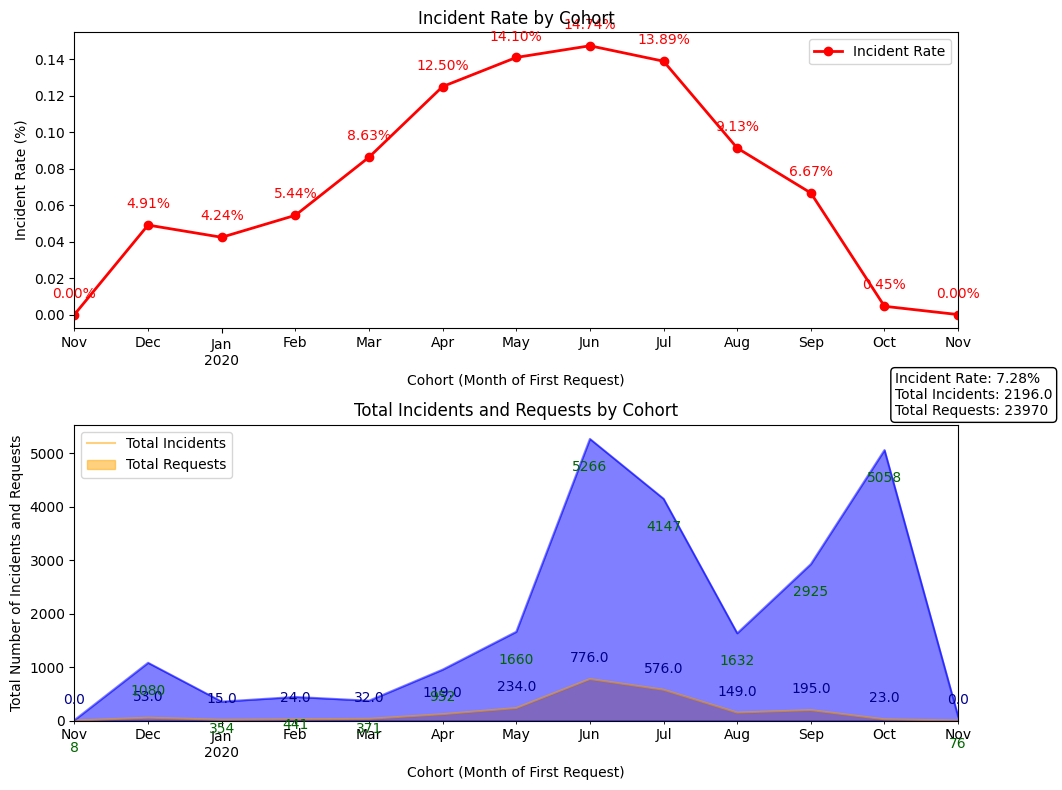

In [11]:
import matplotlib.pyplot as plt

# Create two subplots, one for the incident rate and one for total requests and total incidents
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot for the incident rate
cohort_incidents['incident_rate'].plot(kind='line', marker='o', ax=ax1, color='red', linewidth=2)
ax1.set_title('Incident Rate by Cohort')
ax1.set_xlabel('Cohort (Month of First Request)')
ax1.set_ylabel('Incident Rate (%)')
ax1.legend(['Incident Rate'], loc='upper right')

# Add data labels for the incident rate
for i, txt in enumerate(cohort_incidents['incident_rate']):
    ax1.annotate(f'{txt:.2%}', (cohort_incidents.index[i], txt), textcoords="offset points", xytext=(0,10), ha='center', va='bottom', color='red')

# Plot for total requests and total incidents
cohort_incidents[['total_incidents', 'total_requests']].plot(kind='area', stacked=False, ax=ax2, alpha=0.5, color=['orange', 'blue'])
ax2.set_title('Total Incidents and Requests by Cohort')
ax2.set_xlabel('Cohort (Month of First Request)')
ax2.set_ylabel('Total Number of Incidents and Requests')
ax2.legend(['Total Incidents', 'Total Requests'], loc='upper left')

# Add data labels for incident and request areas
incident_values = cohort_incidents['total_incidents'].tolist()
request_values = cohort_incidents['total_requests'].tolist()

for i, (inc_val, req_val) in enumerate(zip(incident_values, request_values)):
    ax2.annotate(f'{inc_val}', (cohort_incidents.index[i], inc_val), textcoords="offset points", xytext=(0,10), ha='center', va='bottom', color='darkblue')
    ax2.annotate(f'{req_val}', (cohort_incidents.index[i], req_val), textcoords="offset points", xytext=(0,-15), ha='center', va='top', color='darkgreen')

# Create a custom legend on the right side of the plot
stats_text = f"Incident Rate: {cohort_incidents['incident_rate'].mean():.2%}\n" \
             f"Total Incidents: {cohort_incidents['total_incidents'].sum()}\n" \
             f"Total Requests: {cohort_incidents['total_requests'].sum()}"

# Add the text as an annotation box inside the plot
plt.gcf().text(0.9, 0.5, stats_text, fontsize=10, verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.show()



/var/folders/l8/nzfg4l2524n0y13740c8fkm40000gn/T/ipykernel_13658/717666027.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_requests_df['month'] = cash_requests_df['created_at'].dt.to_period('M')


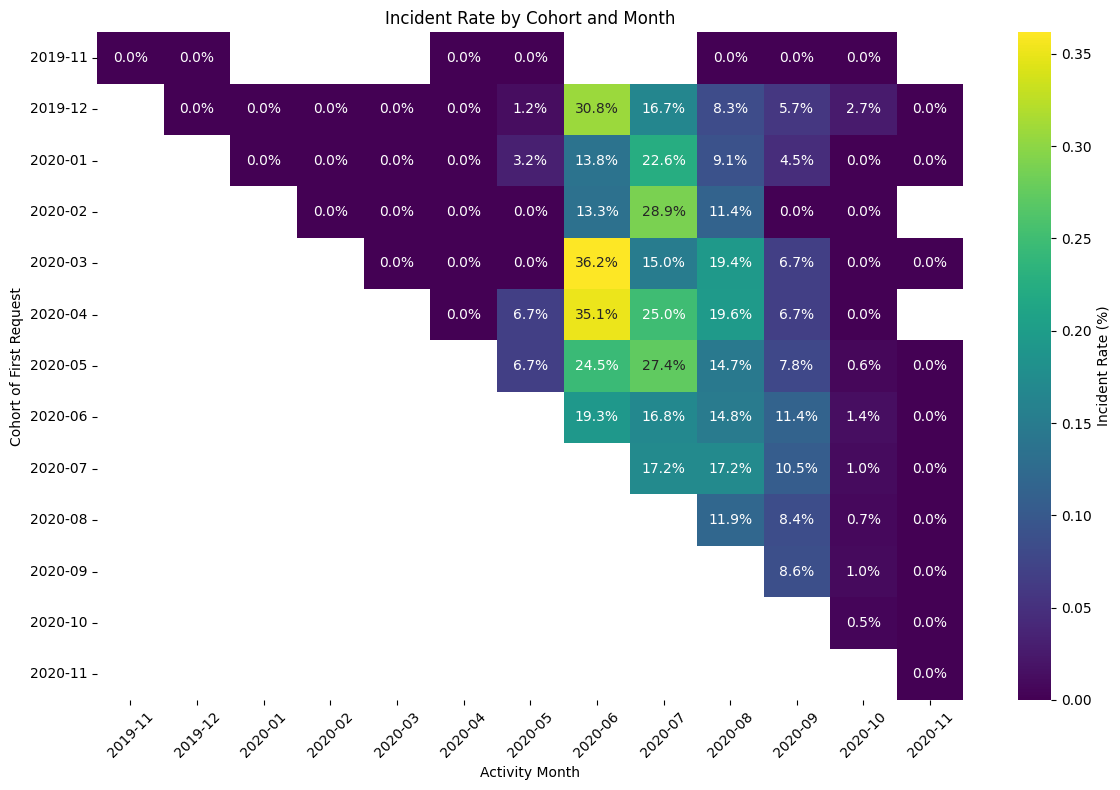

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add a 'month' column to calculate monthly incident rates
cash_requests_df['month'] = cash_requests_df['created_at'].dt.to_period('M')

# Regroup by cohort and month
monthly_cohort_data = cash_requests_df.groupby(['cohort', 'month']).agg(
    monthly_incidents=('incident_count', 'sum'),
    monthly_requests=('id', 'count')
)
monthly_cohort_data['monthly_incident_rate'] = monthly_cohort_data['monthly_incidents'] / monthly_cohort_data['monthly_requests']

# Pivot the data for the heatmap
pivot_table = monthly_cohort_data['monthly_incident_rate'].unstack(level=1)  # Unstack by month

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".1%", cbar_kws={'label': 'Incident Rate (%)'})
plt.title('Incident Rate by Cohort and Month')
plt.xlabel('Activity Month')
plt.ylabel('Cohort of First Request')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

